# Controlled

The controlled protocol lets you request a 'controlled' version of a bloq.

A key feature of any program is the ability to do branching. That is, choose what operations to do based on input. The primitive branching feature in quantum algorithms is the idea of a controlled bloq.

In its simplest form, a control bit is specified as an (additional) input to a bloq and the bloq is active when the control input is in the $|1\rangle$ state. Otherwise, the bloq's operation is not performed (said another way: the Identity bloq is performed). The control input can be in superposition. 

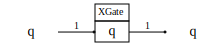

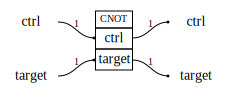

In [1]:
from qualtran.drawing import show_bloq
from qualtran.bloqs.basic_gates import XGate

x = XGate()

show_bloq(x)
show_bloq(x.controlled())

## Interface

The method for accessing the controlled version of a bloq is calling `Bloq.controlled(ctrl_spec)`. `ctrl_spec` is an instance of `CtrlSpec` which specifies how to control the bloq. 

`CtrlSpec` supports additional control specifications:
 1. 'negative' controls where the bloq is active if the input is |0>.
 2. integer-equality controls where a `bitsize`-sized input must match an integer control value.
 3. ndarrays of control values, where the bloq is active if **all** inputs are active.
 4. Multiple control registers, control values for each of which can be specified
    using 1-3 above.

For example:
 
 1. `CtrlSpec(qdtypes=QUInt(4), cvs=0b0110)`: Ctrl for a single register, of type `QUInt(4)` and shape `()`, is active when the soquet of the input register takes value 6.

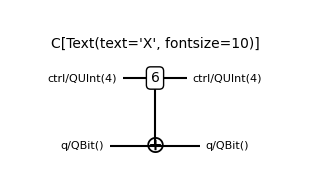

In [2]:
from qualtran import CtrlSpec, QUInt, QBit

ctrl_spec = CtrlSpec(qdtypes=QUInt(4), cvs=0b0110)
assert ctrl_spec.is_active(6)
cx = x.controlled(ctrl_spec=ctrl_spec)
show_bloq(cx, type='musical_score')

 2. `CtrlSpec(cvs=[0, 1, 1, 0])`: Ctrl for a single register, of type `QBit()` and shape `(4,)`, is active when soquets of input register take values `[0, 1, 1, 0]`.

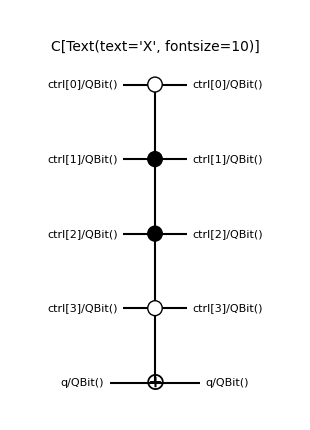

In [3]:
ctrl_spec = CtrlSpec(cvs=[0, 1, 1, 0])
assert ctrl_spec.is_active([0, 1, 1, 0])
cx = x.controlled(ctrl_spec=ctrl_spec)
show_bloq(cx, type='musical_score')

 3. `CtrlSpec(qdtypes=[QBit(), QBit()], cvs=[[0, 1], [1, 0]]).is_active([0, 1], [1, 0])`:
    Ctrl for 2 registers, each of type `QBit()` and shape `(2,)`, is active when the soquet for
    each register takes values `[0, 1]` and  `[1, 0]` respectively.

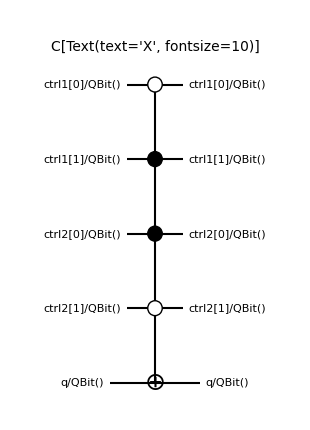

In [4]:
import numpy as np

ctrl_spec = CtrlSpec(qdtypes=[QBit(), QBit()], cvs=[[0, 1], [1, 0]])
assert ctrl_spec.is_active([0, 1], [1, 0])
cx = x.controlled(ctrl_spec=ctrl_spec)
show_bloq(cx, type='musical_score')

The controlled bloq is defined by its decomposition in addition to its classical and quantum simulation protocols. For a general bloq, we can provide a decomposition of its controlled version by controlling each of the subbloqs.

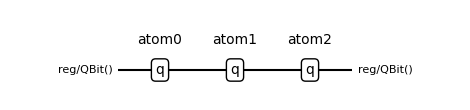

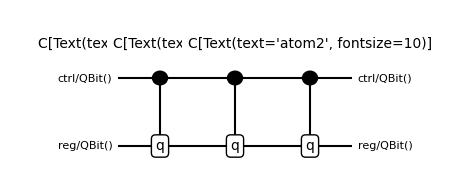

In [5]:
from qualtran.bloqs.for_testing import TestSerialCombo

serial = TestSerialCombo()
cserial = serial.controlled()
show_bloq(serial.decompose_bloq(), type='musical_score')
show_bloq(cserial.decompose_bloq(), type='musical_score')

## Implementation

Bloq authors can override `Bloq.get_ctrl_system(...)` to provide a custom controlled version of a bloq. Please read the docstrings for this method to understand the required return values.

We've already seen an example where `XGate().controlled()` will give the `CNOT` bloq. 

In [6]:
cx = XGate().controlled()
print(cx)

CNOT


This behavior may depend on the control spec. For example, if we want to control on the input line being in the state corresponding to the unsigned integer `255`, we wouldn't get a `CNOT` bloq.

C[8][XGate]


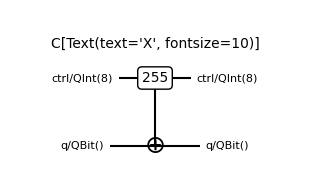

In [7]:
from qualtran import QInt
c255x = XGate().controlled(CtrlSpec(QInt(8), cvs=255))
show_bloq(c255x, type='musical_score')
print(c255x)

## Default Fallback

If a bloq does not override `get_ctrl_system`, the system will use the `qualtran.Controlled` meta-bloq to wrap the original bloq

In [8]:
from qualtran.bloqs.for_testing import TestAtom

atom = TestAtom()
catom = atom.controlled()
catom

Controlled(subbloq=TestAtom(), ctrl_spec=CtrlSpec(qdtypes=(QBit(),), cvs=(array(1),)))

This metabloq forms an important part of the 'controlled' protocol. It adapts the other qualtran protocols to handle controlled versions of arbitrary bloqs. It delegates its protocols to the wrapped bloq.

 - **Signature:** That of the wrapped bloq with new registers according to `ctrl_spec`.
 - **Decomposition:** The controlled version of a composite bloq is formed by controlling each
   of the subbloqs.
 - **Classical simulation:** This uses the control spec’s activation method to check classical values.
   If the gate is meant to be active, the wrapped classical simulation protocol is employed.
   Otherwise: the input values are returned unchanged.
 - **Tensor simulation:** Currently, tensor simulation will proceed via the decomposition.
 - **Call graph:** The wrapped bloq's call graph with controlled versions of each subbloq.
 - **Wire_symbol:** Existing registers delegate to the wrapped bloq. New control registers use the
   wire symbol information provided by the control spec.
 - **Names:** The wrapped bloq's names encased with "C[...]"
 - **Adjoint:** Use the default fallback. The control lines are all symmetric.
 - **Cirq**: Use the default fallback. No translation to `cirq.ControlledOperation` is done.

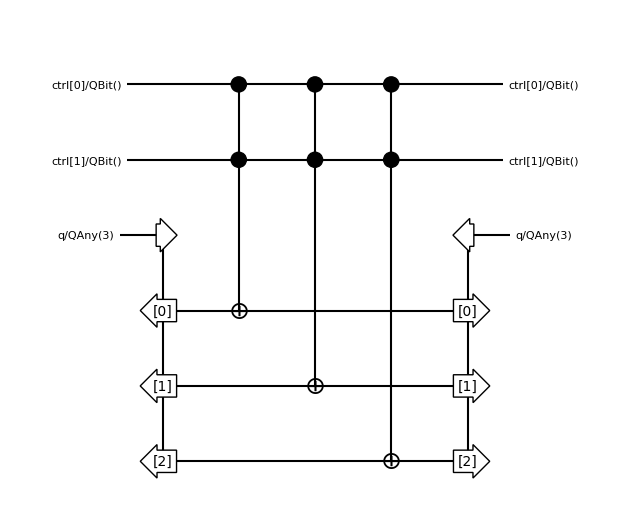

In [9]:
# Use the default fallback for `OnEach`; but the subbloqs all have custom
# controlled behavior: 
#  C^2[X]        -> Toffoli
#  C[Split/Join] -> Split/Join
from qualtran.bloqs.basic_gates import OnEach

ccx3 = OnEach(n=3, gate=x).controlled(CtrlSpec(cvs=(1,1)))
show_bloq(ccx3.decompose_bloq(), type='musical_score')